In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
import itertools
import pickle

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor, StackingClassifier)

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.datasets import fetch_california_housing

In [3]:
def plot_decision_regions(x, y, clf, ax=None, palette='colorblind', 
                          alpha=0.8, points=1e3, title=None):
    '''
    Plot decision regions for classifier `clf` and true values (x, y) in `x`, `y`.
    
    x, y: np.array
        data
    ax: matplotlib.axes
        plotting axis
    palette: str or seaborn palette
        color palette
    alpha: int
        scatter alpha (contour alpha is alpha/2, but with zorder=0)
    points: int
        number of points to predict for the contour
    title: str
        title for the plot
    '''
    
    # Set up an axis to plot our boundary
    if ax is None:
        fig, ax = plt.subplots()
    
    # save the results of a function like `clf = model.predict`
    y_pred = clf.predict(x)
    
    # plot the true data
    sns.scatterplot(x=x[:, 0], 
                    y=x[:, 1], 
                    hue=y, 
                    alpha=alpha, 
                    edgecolor='k', 
                    palette=palette, 
                    ax=ax)

    side_pts = int(np.sqrt(points))

    x0_min, x0_max = ax.get_xlim()
    x1_min, x1_max = ax.get_ylim()
    
    xx, yy = np.meshgrid(
        np.linspace(x0_min, x0_max, num=side_pts),
        np.linspace(x1_min, x1_max, num=side_pts))
    
    # x contains two features (w0 = xx, and w1 = yy). 
    # plot [w0, w1] preds as a color given the features correspond to xx and yy axes
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # plot the contour (prediction colors, `Z`)
    levels = len(np.unique(Z)) - 1
    ax.contourf(xx, yy, Z, 
                alpha=alpha/2, 
                levels=levels, 
                colors=sns.color_palette(palette), 
                zorder=0)
    
    ax.set_title(title)
    
    return ax

# Bagging

**Bootstrap aggregating**, more commonly referred to as **bagging**, is a type of machine learning algorithm that is designed to improve the accuracy and stability of the model. We will discuss bootstrapping and aggregating below, but we'll first outline the algorithm itself.

The Bagging algorithm is fairly simple:

Given a training set $T = \{(x_1, y_1), \ldots, (x_n, y_n)\}$

- Sample $k$ sets of $n$ elements from $T$ (with replacement), giving sets $T_1, \ldots, T_k$
- Train an algorithm on each $T_i, i=1, \ldots, k$ and obtain a sequence of $k$ outputs $f_1(\mathbf{x}), \ldots, f_k(\mathbf{x})$


The final aggregate classifier is:

**for Regression** - take the average of all of the predictions
$$\bar{f}(\mathbf{x}) = \frac{1}{k} \sum_{i=1}^k f_i(\mathbf{x})$$

**for Classification** there are a few options, which are covered in more depth later in this lesson including:
- Average Voting
- Max Voting




Here is a nice visual representation of the bagging algorithm

![](images/bagging.jpg)

## Bootstrapping

Bootstrapping is a sampling technique. Out of the $n$ samples in our dataset, $k$ samples are chosen **with replacement**. 

We'll use income data to see how this works in action

In [4]:
df = pd.read_csv('data/incomes.csv')
incomes = df['income'].values

In [5]:
def get_random_indices(num):
    return np.random.randint(0, num, num)

def get_random_sample(X):
    indices = get_random_indices(len(X))
    return X[indices]

def get_sample_median(X):
    sample = get_random_sample(X)
    return np.median(sample)

In [6]:
medians = [get_sample_median(incomes) for _ in range(200)]

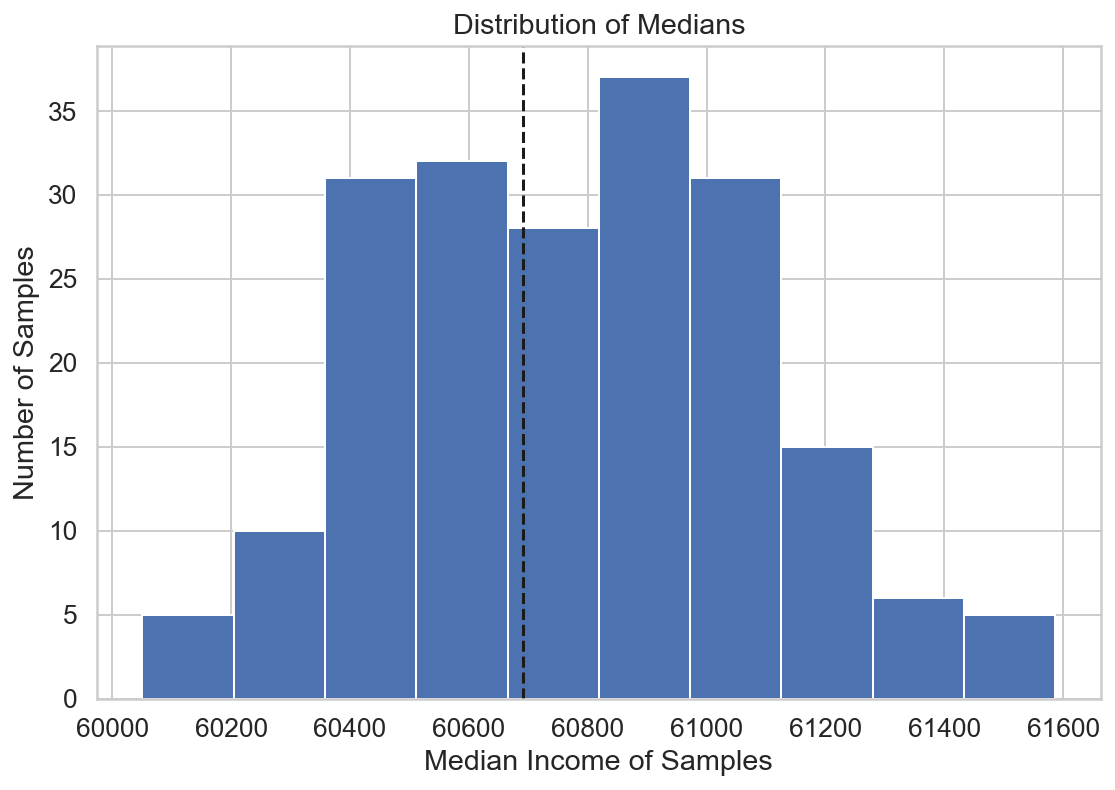

In [7]:
plt.hist(medians)
plt.title('Distribution of Medians')
plt.xlabel('Median Income of Samples')
plt.ylabel('Number of Samples')

# Plot real median value
whole_sample_median = np.median(incomes)
plt.gca().axvline(whole_sample_median, ls='--', c='k');

When we get a dataset to build a machine learning model, we can only say what the sample median is for this dataset, but not necessarily what the true population median is. In other words, our sample median may be different from the true population median and we need a way to look at many different subsets to generalize. This is what we calculated in the figure above. 

What happens if we don't bootstrap? Well, it's probable that we can get a biased sample that will fail to generalize, i.e., we will overfit our model. 

As with any statistical sampling method, we prefer to look at the *distribution* of our feature and find a 95% likelihood cut-off.

In [8]:
# What are the percentiles? This gives us a range of values 
# that the sample median lies in 95% of the samples
lower, upper = np.percentile(medians, 2.5), np.percentile(medians, 97.5)
print(f"95% of bootstrapped medians fall within {lower, upper}")

95% of bootstrapped medians fall within (60220.925, 61383.9625)


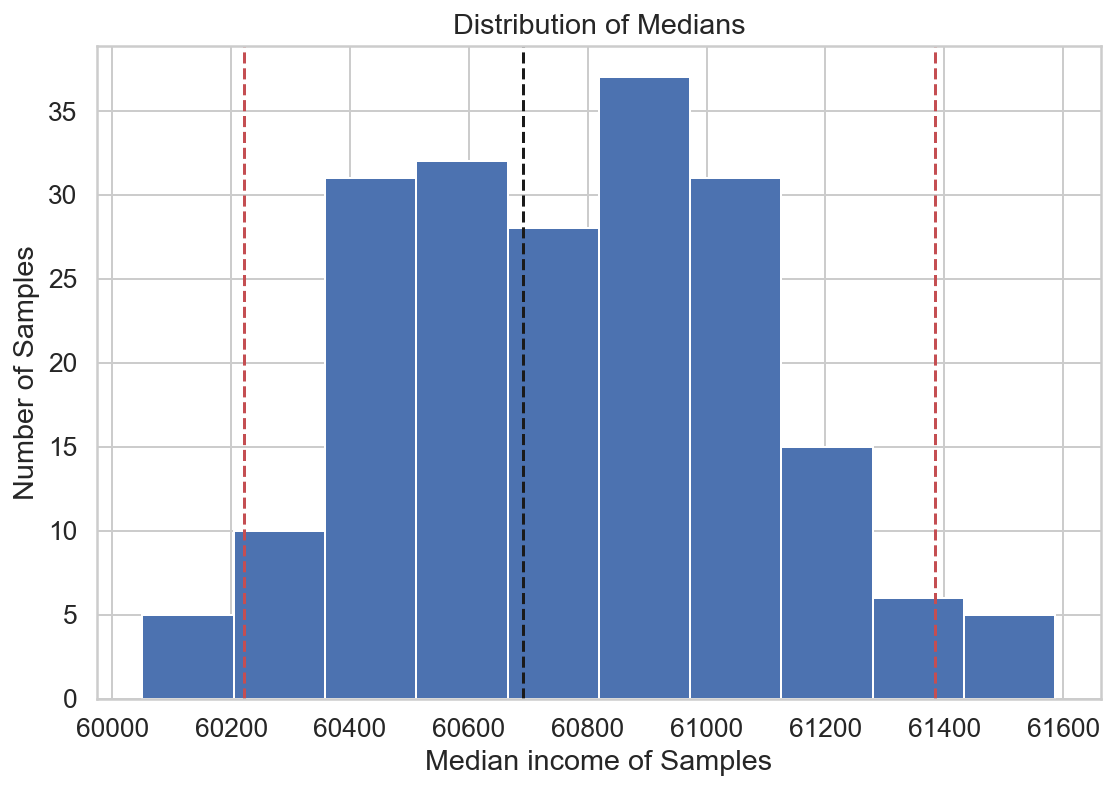

In [9]:
plt.hist(medians)
plt.title('Distribution of Medians')
plt.xlabel('Median income of Samples')
plt.ylabel('Number of Samples')

plt.gca().axvline(whole_sample_median, ls='--', c='k')
plt.gca().axvline(lower, ls='--', c='r')
plt.gca().axvline(upper, ls='--', c='r');

## Aggregating

### Variance and Bias (a review)

Recall that a model, $\mathcal{M}$ is made up of two (kinds of) components:

1. Parameters, $\Theta$ (e.g., $\Theta = \beta$ in linear regression)
2. Instructions on what to do with an input $\mathbf{x}$, given those parameters (e.g., perform a linear combination)

When we say a model $\mathcal{M}$ (e.g., "The Decision Tree") has "high variance", we mean that the *parameters* which specify this model will vary heavily with different training sets. When we talk about "bias" in a model, we mean the amount to which the *instructions* of the model stray from the true relationship between feature and target. So, when we say a model has "high bias", we mean the instructions (or operations, what have you) guide us far away from the relevant relations between the features and the target.

### Why ensemble?

Recall from an earlier lesson that (strong) Decision Trees are prone to high variance. They will find complex, nonlinear ways to get the highest accuracy from the data, but it comes at the cost of overfitting to the training set.

Now, each one of these decision trees is low bias (good at capturing relevant relations), but high variance (highly specific to the data it's trained on). If we employ a different decision tree for each random sample of our data, we should be able to **maintain the relavent relations in these samples**, and **correct for the variance (i.e., generalize)** by aggregating the results from these different "views" of the population (i.e., each sub-sample from our data).

Let's see this in action using the California Housing data.

In [10]:
data = fetch_california_housing()

In [11]:
X = data.data
y = data.target

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [13]:
# confirm our model is overfitting
dt_model = DecisionTreeRegressor(random_state=123)
dt_model.fit(X_train, y_train)
print(f'Train R^2 Score: {np.round(dt_model.score(X_train, y_train), 4)}')
print(f'Test R^2 Score: {np.round(dt_model.score(X_test, y_test), 4)}')

Train R^2 Score: 1.0
Test R^2 Score: 0.6044


**Note:**  
We can [decompose](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#Derivation) a model's expected error on unseen data as a combination of three things: 1) Model bias, 2) Model variance, and 3) Irreducible error; that is, if $\hat{f}$ is our model, 
$$ {\displaystyle {\begin{aligned}\operatorname {E} {\Big [}{\big (}y-{\hat {f}}(x){\big )}^{2}{\Big ]}&={\Big (}\operatorname {Bias} {\big [}{\hat {f}}(x){\big ]}{\Big )}^{2}+\operatorname {Var} {\big [}{\hat {f}}(x){\big ]}+\sigma ^{2}\\\end{aligned}}} $$

We often think about the "bias-variance tradeoff" in data science, which just means that predictive models with lower bias in parameter estimation often have higher variance, and vice versa.  That is, reducing one by changing model complexity often increases the other.

<center>
    <img src="images/bias-variance.png">
</center>

Below, however, we will show that ensembling reduces variance, but does not signficantly increase bias -- woot!

In [14]:
def bias_metric(y_true, y_pred):
    return np.mean((np.mean(y_pred) - y_true)**2)

def variance_metric(y_true, y_pred):
    return np.var(y_true - y_pred)

In [15]:
# Run bagging classifier through cross validation
# ~45s to run
# instructor: pull up the bagging classifier docs if useful
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

variance = []
bias = []
test_range = np.arange(1, 30, 1)

for i in test_range:
    cv_out = cross_validate(
        estimator=BaggingRegressor(DecisionTreeRegressor(random_state=123), 
                                   n_estimators=i),
        X=X_train,
        y=y_train,
        cv=3,
        return_train_score=True,
        scoring={
            "variance": make_scorer(variance_metric),
            "bias": make_scorer(bias_metric)
        },
        n_jobs=-1,  #Possible issues if sklearn.__version__ < 0.20.1; If error, switch to n_jobs=1
    )
    variance.append(np.mean(cv_out['test_variance']))
    bias.append(np.mean(cv_out['test_bias']))


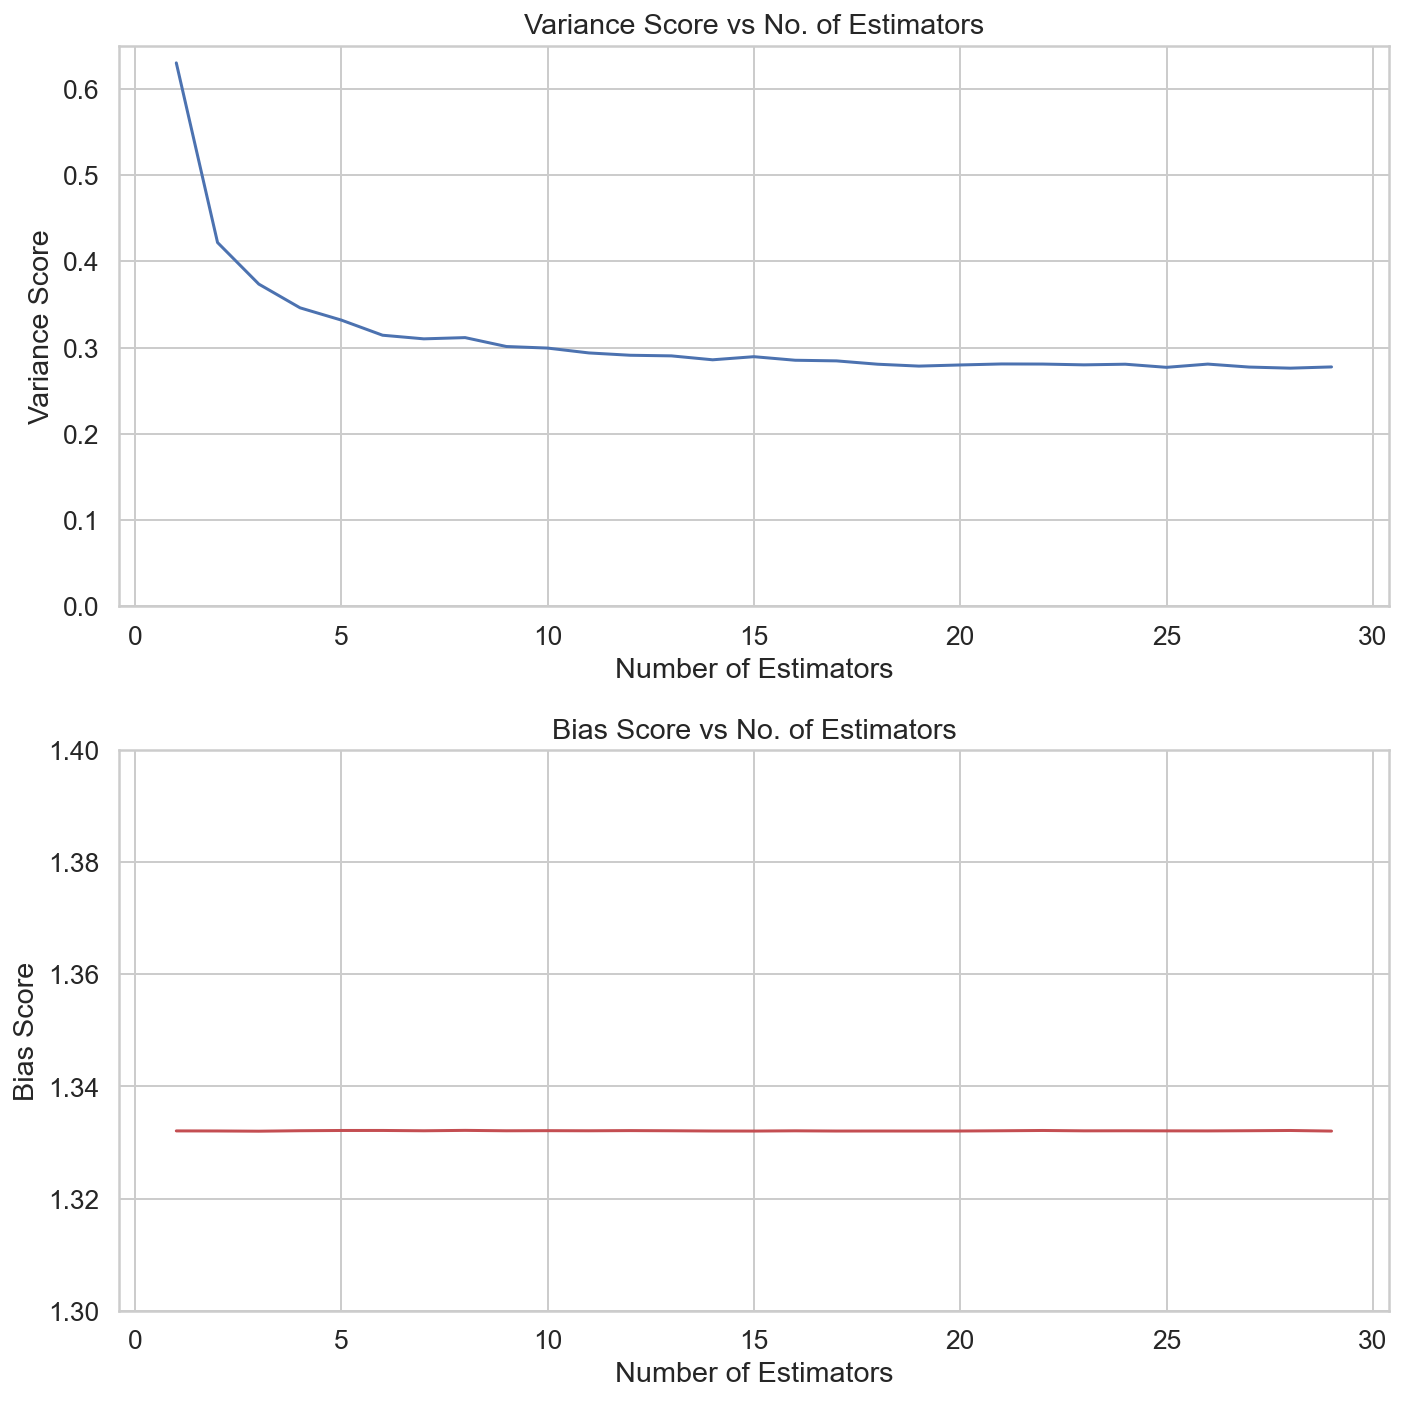

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(test_range, variance, label='variance')
axes[0].set_ylim((0, 0.65))
axes[0].set_xlabel('Number of Estimators')
axes[0].set_ylabel('Variance Score');
axes[0].set_title('Variance Score vs No. of Estimators');

axes[1].plot(test_range, bias, label='bias', c='r')
axes[1].set_ylim((1.3, 1.4))
axes[1].set_xlabel('Number of Estimators')
axes[1].set_ylabel('Bias Score');
axes[1].set_title('Bias Score vs No. of Estimators');

plt.tight_layout()

From the graph above, we can see there is a clear reduction in the variance when increasing the number of estimators.

# Ensemble Methods

In the previous section we talked about Bagging and how it reduces variance. But there are many more types of ensemble models. The Bagging classifier, allows us to look at the same data through the lens of many bootstrapped samples... But, we're only able to use one classifier to train each bootstrapped sample.

This begs the question: **Can we apply the same logic from bagging to use not just one model, but many different kinds of models as well?**

Fortunately, the answer is **yes** and this section will provide how we can use this "best-of-breed" approach to build different ensemble models.

# Intuition

Before we dive into the nitty-gritty we'll use an analogy to drive what we want to achieve from our ensemble model.

There is an old parable, called "The Blind Men and the Elephant" [wikipedia](https://en.wikipedia.org/wiki/Blind_men_and_an_elephant).

The gist is the following:

> A group of blind men have never seen an elephant before. They all are curious to learn what the elephant is like, so each blind man feels a different part of the elephant's body, but only one part, such as the side or the tusk. They then describe the elephant based on their limited experience and their descriptions of the elephant are different from each other.

Sounds pretty similar to what data scientists do!

![](images/elephant.jpeg)

We can think of each blind man as an individual "model" that comes with certain biases and different decision as to what the elephant is like. Fortunately, we don't have to take the recommendation of one model only, we can take all of those recommendations ourselves and decide what makes up an elephant.

This is, in essence, what any ensemble model is trying to do. It will look at all of the recommendations from different kinds of models and then make a decision based on the aggregate of all of the responses.

# Voting Classifier

One of the most common ensemble models is the Voting Classifier. It does what its name implies, looks at the votes of the pre-trained algorithms and gives an output.

<img src="images/ensemble.png" alt="" width="500" height="600"/>

There are 3 different flavors for voting classifier which we will discuss.

- Max Voting
- Average Voting
- Weighted Voting

But, before we get into all the fun stuff, let's load some data and pre-trained models.

In [17]:
df = pd.read_csv('data/dataframe.csv')

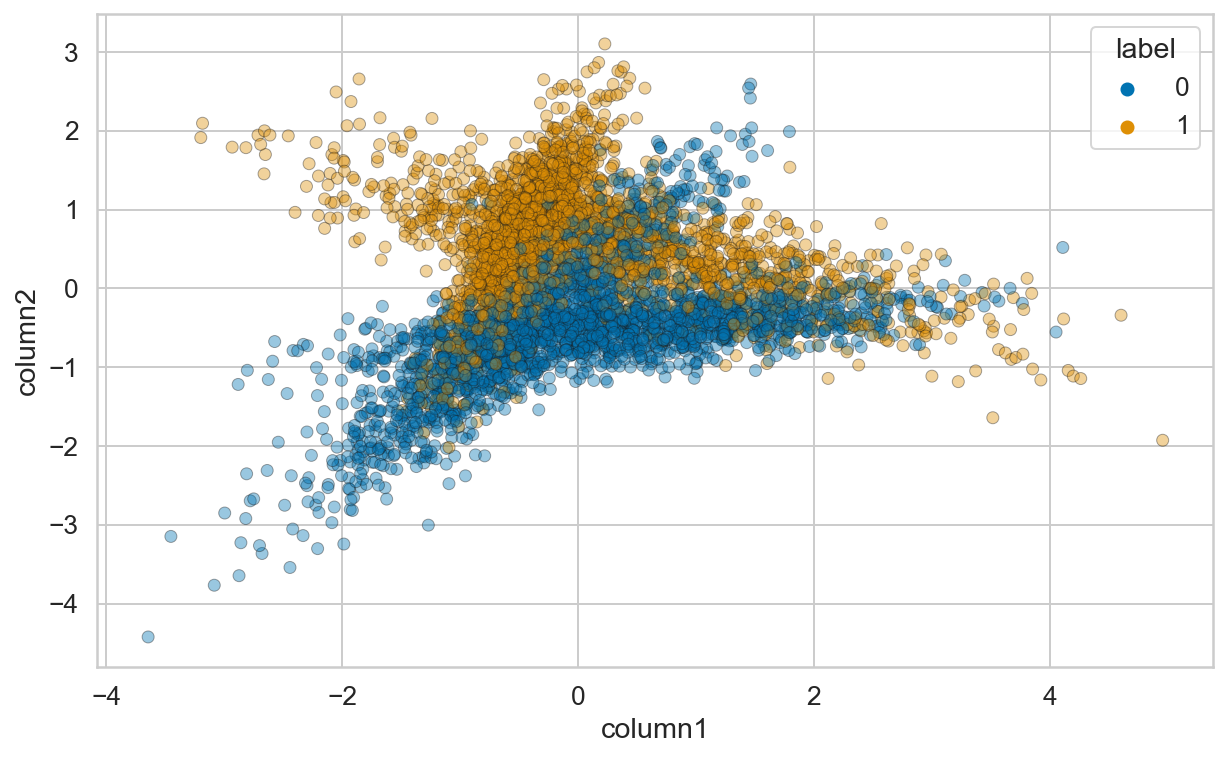

In [18]:
sns.scatterplot(x='column1', y='column2', 
                data=df, hue='label',
                palette='colorblind', alpha=.4, edgecolor='k')

plt.gcf().set_size_inches(10,6);

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df.label, random_state=123)

In [20]:
# Load pre-trained/tuned models

model_names = ["lr_model", "nb_model", "knn_model", "svc_model", "rf_model", "et_model", "ada_model"]

for model_name in model_names:
    with open(f"models/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [21]:
# Quick peek at each model performance

for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_test, y_test)}')

lr_model score: 0.7976
nb_model score: 0.7936
knn_model score: 0.8112
svc_model score: 0.84
rf_model score: 0.8112
et_model score: 0.7968
ada_model score: 0.816


## Max Voting

The basic assumption for the max voting algorithm is easy: Take the class that has the largest number of predictions for each model.

**Classifier 1 -> Class 0**

**Classifier 2 -> Class 1**

**Classifier 3 -> Class 1**

In the example above, our max voting method would choose class 1.

One item to be aware of is what happens with ties. Say we had the following outputs:

**Classifier 1 -> Class 0**

**Classifier 2 -> Class 1**

**Classifier 3 -> Class 1**

**Classifier 4 -> Class 0**


In this scenario, the max voting method chooses class 0 since the algorithm breaks the tie by looking at the output from the **last** classifier (sorted alphabetically by name).

### Visualize output from each model

Looking at decision regions will help us solidify how the algorithm is working.

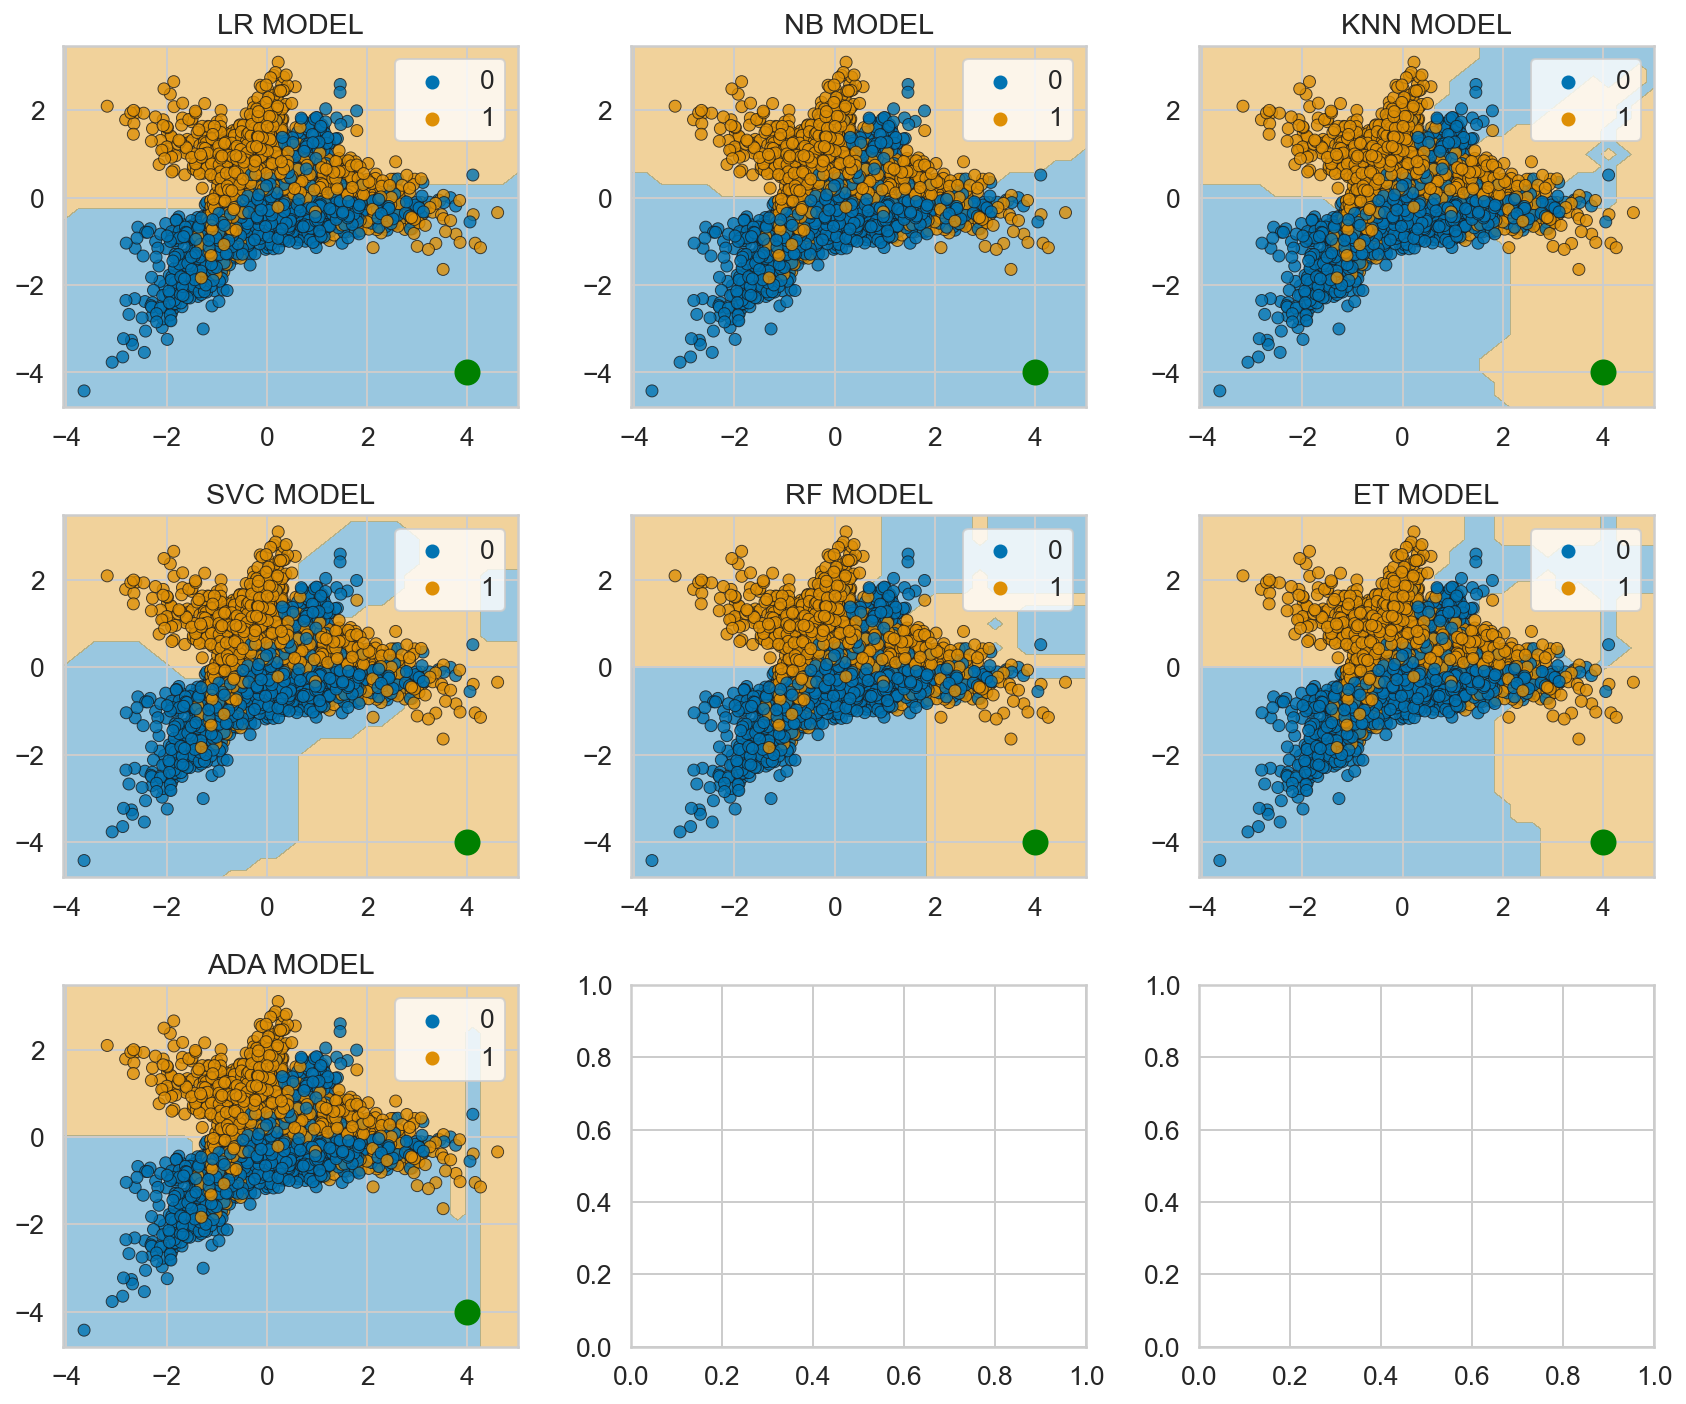

In [23]:
# Plot decision region for each model.
fig, axes = plt.subplots(3, 3)

# itertools.product() *generates* all coordinate pairs for a given set
for model_name, grd_i in zip(model_names, itertools.product([0, 1, 2], repeat=2)):

    clf = eval(model_name)

    ax = axes[grd_i[0], grd_i[1]]
    
    plot_decision_regions(
        x=X_train.values,
        y=y_train.values,
        clf=clf,
        ax=ax,
        title=model_name.replace('_', ' ').upper())
    
    ax.plot([4], [-4], marker='o', markersize=12, color='green')

plt.gcf().set_size_inches(12, 10)
plt.tight_layout()
plt.show()

Let's put our knowledge of the max voting method to use. 

**Focusing only on the green dot in the lower right corner, what prediction do we expect our model to give us for the ensemble classifier?**

**Answer**: Looking at the output from each of the models, we have three models predicting class 0 (Log Reg, Naive Bayes, and the adaptive, ADA, model) and the other four models predicting class 1. 

Thus, our model should **predict class 1** as it has more votes.

Let's verify that this is indeed the case by running our ensemble classifier.

In [24]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', # <-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression()),
                             ('nb_model', GaussianNB()),
                             ('knn_model', KNeighborsClassifier()),
                             ('svc_model', SVC(probability=True)),
                             ('rf_model', RandomForestClassifier()),
                             ('et_model', ExtraTreesClassifier()),
                             ('ada_model', AdaBoostClassifier())],
                 n_jobs=-1)

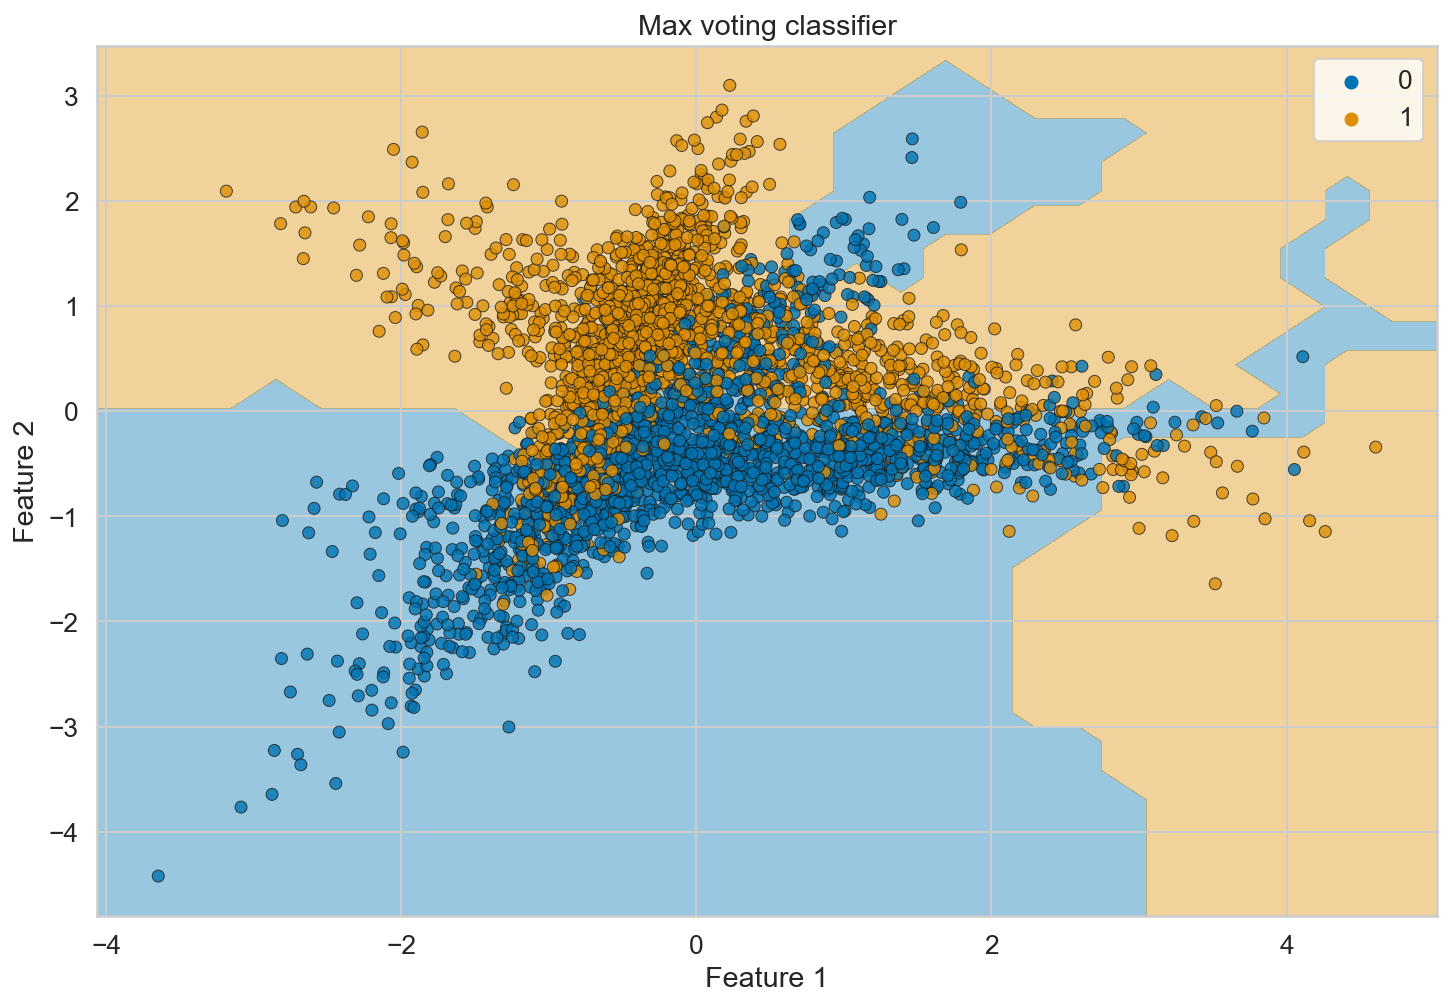

In [25]:
# Plot model
plot_decision_regions(X_train.values, y_train.values, voting_classifer)
plt.title('Max voting classifier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

**Et voilà!**

Our ensemble classifier chose class 1 for our lower right corner, just like we expected.


Like any other model in `sklearn` we can see how our ensemble model performing on the test data. Ideally, we'd like to beat our best performing individual model, but this is **not** always guaranteed to happen. (No Free Lunch Theorem)


In [26]:
# Get accuracy (model to beat: SVC with ~0.84 accuracy)
y_pred = voting_classifer.predict(X_test)
accuracy_score(y_test, y_pred)

0.8312

Not an improvement, but our ensemble classifier would be tied for 2nd place out of all of our models.

## Average Voting

In average voting (aka soft voting), we predict the class labels based on the predicted probabilities $p$ for classifier.

Ultimately, the algorithm will decide which class has the highest sum of probabilities, i.e.,

$$\hat{y} = \arg \max_i \sum_{j=1}^k p_{ij}$$

where $i$ is the number of classes and $k$ is the number of models.



In our example we are looking at a binary classification task with class labels $i \in \{0,1\}$. Imagine our ensemble is making the following predictions:

- $\mathbf{C}_1(\mathbf{x}) \rightarrow [0.9, 0.1]$ 
- $\mathbf{C}_2(\mathbf{x}) \rightarrow [0.8, 0.2]$
- $\mathbf{C}_3(\mathbf{x}) \rightarrow [0.4, 0.6]$ 



Using uniform weights, the average probabilities are the following:

$$p(i_0 | \mathbf{x}) = \frac{0.9 + 0.8 + 0.4}{3} = 0.7 $$

$$p(i_1 | \mathbf{x}) = \frac{0.1 + 0.2 + 0.6}{3} = 0.3 $$

$$\hat y = \arg \max_i [p(i_0 | \mathbf{x}), p(i_1 | \mathbf{x})] = 0 $$

In [27]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft', # <-- sklearn calls this soft voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression()),
                             ('nb_model', GaussianNB()),
                             ('knn_model', KNeighborsClassifier()),
                             ('svc_model', SVC(probability=True)),
                             ('rf_model', RandomForestClassifier()),
                             ('et_model', ExtraTreesClassifier()),
                             ('ada_model', AdaBoostClassifier())],
                 n_jobs=-1, voting='soft')

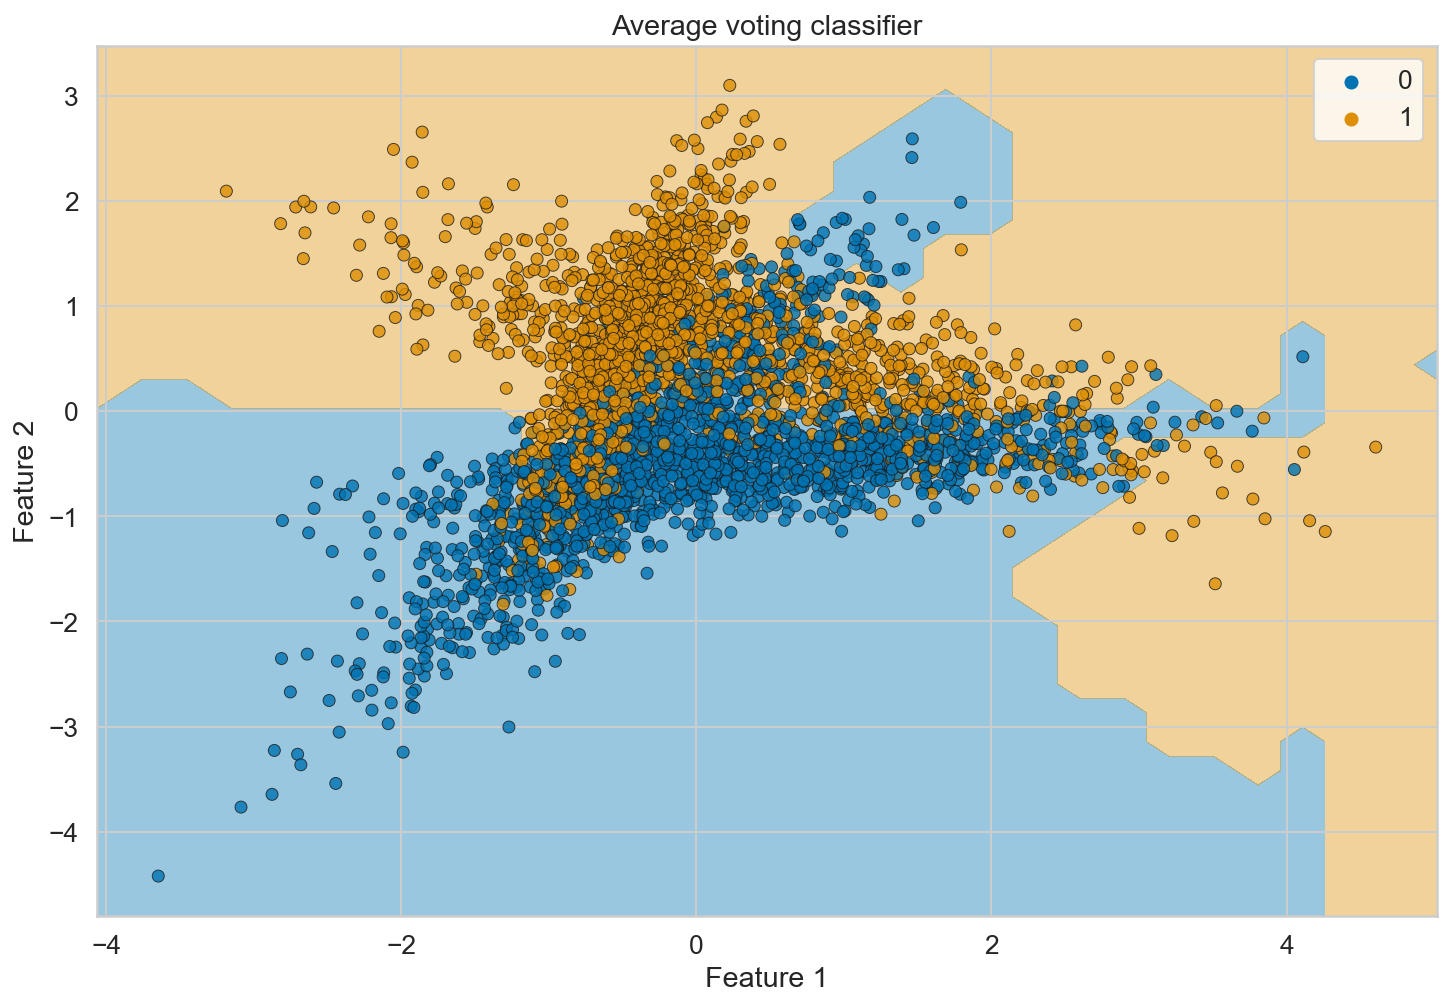

In [28]:
# Plot model
plot_decision_regions(X_train.values, y_train.values, voting_classifer)
plt.title('Average voting classifier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

Note that our decision regions have changed! 

In [29]:
# Get accuracy (model to beat: SVC with ~0.84 accuracy)
y_pred = voting_classifer.predict(X_test)
accuracy_score(y_test, y_pred)

0.8296

Still no improvement...

# Weighted Voting

As the name implies, we'll be assigning weights to each model to adjust its contribution to the final prediction. There will be times when you want to give additional weight to models that are performing better to increase the optimization metric.

Mathematically speaking, there is very little change to the Average Voting method we just saw. All we do is add a weight to each probability, i.e.,

$$\hat{y} = \arg \max_i \sum_{j=1}^k w_j p_{ij}$$

where $i$ is the number of classes, $w_j$ is the model weight, and $k$ is the number of models.


Imagine our ensemble is making the same predictions as before:

- $\mathbf{C}_1(\mathbf{x}) \rightarrow [0.9, 0.1]$ 
- $\mathbf{C}_2(\mathbf{x}) \rightarrow [0.8, 0.2]$
- $\mathbf{C}_3(\mathbf{x}) \rightarrow [0.4, 0.6]$ 



Using weights for each model with value $\{0.1, 0.1, 0.8\}$, the results are the following:

$$p(i_0 | \mathbf{x}) = 0.1*0.9 + 0.1*0.8 + 0.8*0.4 = 0.49 $$

$$p(i_1 | \mathbf{x}) = 0.1*0.1 + 0.1*0.2 + 0.8*0.6 = 0.51 $$

$$\hat y = \arg \max_i [p(i_0 | \mathbf{x}), p(i_1 | \mathbf{x})] = 1 $$

In [30]:
model_names

['lr_model',
 'nb_model',
 'knn_model',
 'svc_model',
 'rf_model',
 'et_model',
 'ada_model']

In [31]:
# create voting classifier
weights = [1.5,2.3,3.8,4.2,4.2,2.2,1.1]
voting_model = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    weights = weights,
                                    n_jobs=-1)
voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression()),
                             ('nb_model', GaussianNB()),
                             ('knn_model', KNeighborsClassifier()),
                             ('svc_model', SVC(probability=True)),
                             ('rf_model', RandomForestClassifier()),
                             ('et_model', ExtraTreesClassifier()),
                             ('ada_model', AdaBoostClassifier())],
                 n_jobs=-1, voting='soft',
                 weights=[1.5, 2.3, 3.8, 4.2, 4.2, 2.2, 1.1])

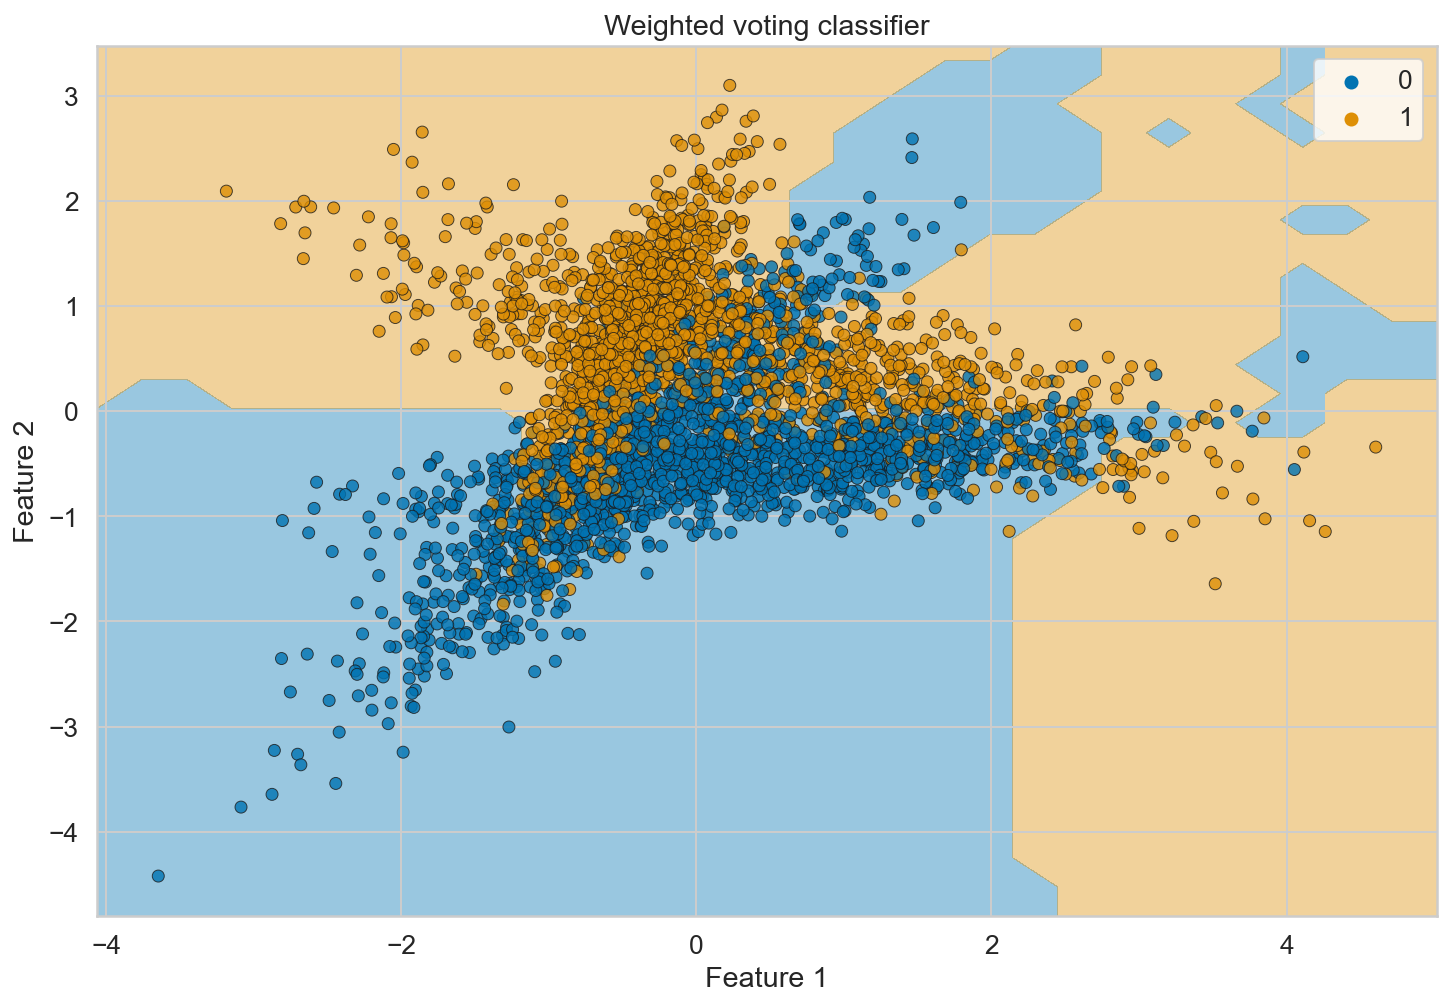

In [32]:
# Plot model
plot_decision_regions(X_train.values, y_train.values, voting_model)
plt.title('Weighted voting classifier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

In [33]:
# Get accuracy (model to beat: SVC with ~0.84 accuracy)
y_pred = voting_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8288

## Visualizing the Weighted Voting System

In [34]:
# predict class probabilities for all classifiers
probas = [c.predict_proba(X_train) for n,c in model_list]
probas += [voting_model.predict_proba(X_train)]

In [35]:
# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]

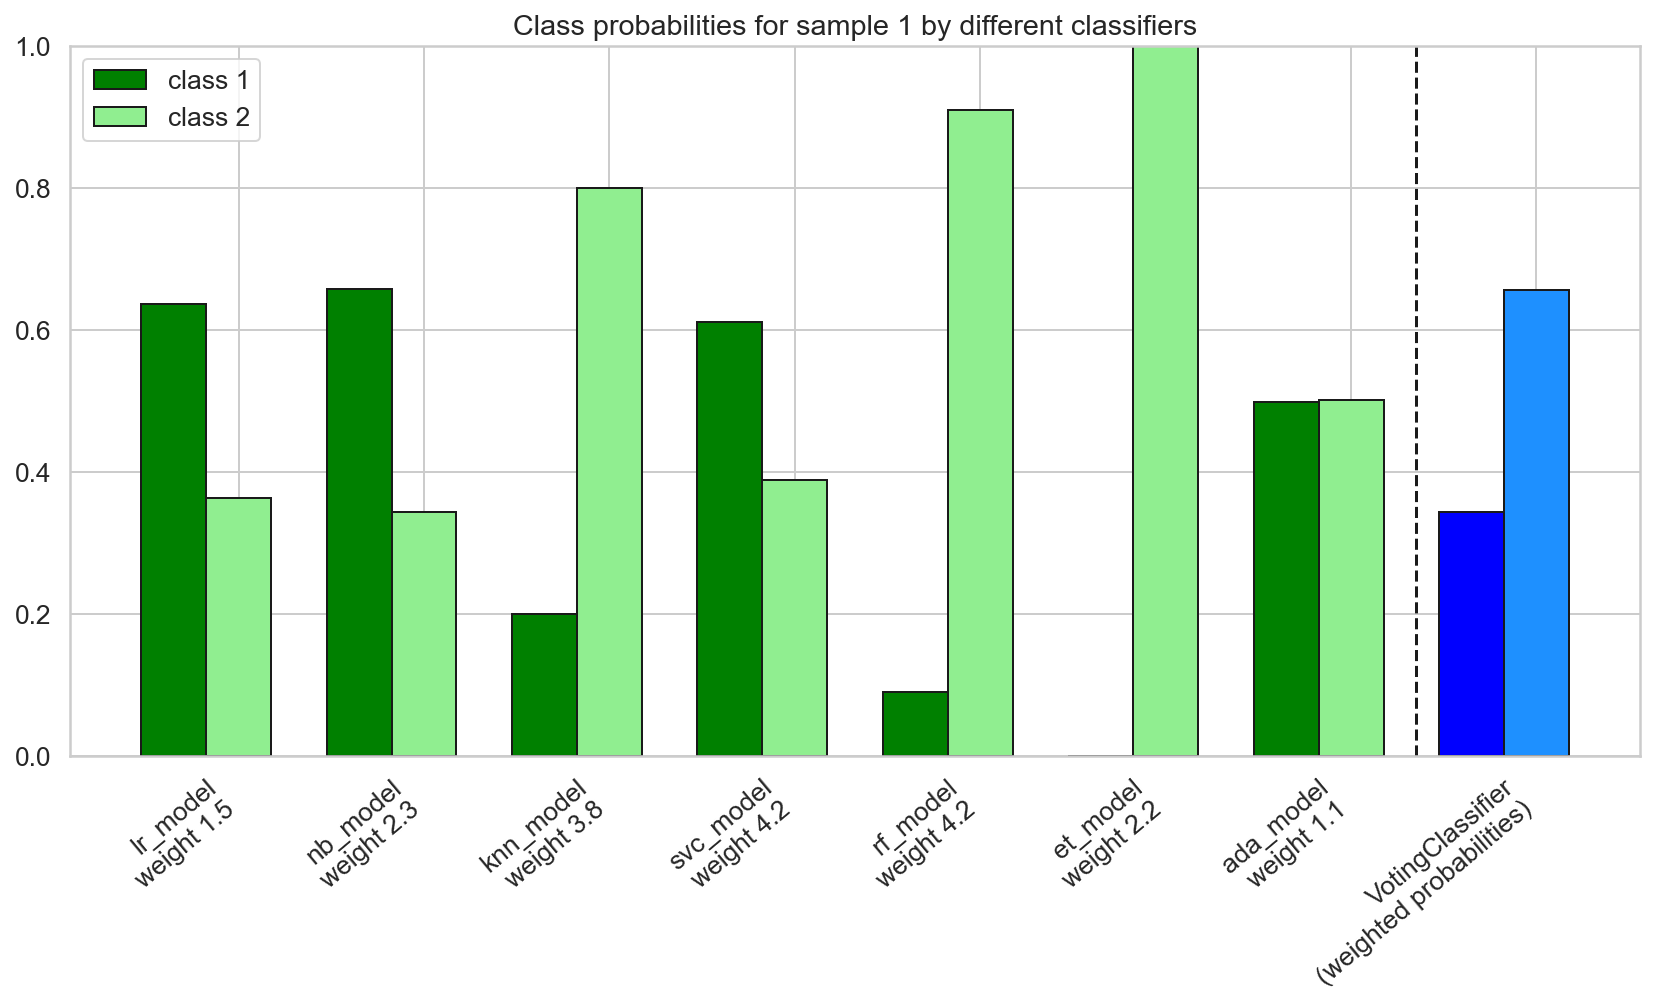

In [36]:
# plotting

N = 8  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-7
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), 
            width,
            color='green', 
            edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), 
            width,
            color='lightgreen', 
            edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0,0,0,0,0,0,0, class1_1[-1]], 
            width,
            color='blue', 
            edgecolor='k')
p4 = ax.bar(ind + width, [0,0,0,0,0,0,0, class2_1[-1]], 
            width,
            color='dodgerblue', 
            edgecolor='k')

# plot annotations
plt.axvline(N - 1.3, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
x_labels = [f"{n}\nweight {weights[i]}" for i, n in enumerate(model_names)]
ax.set_xticklabels(
    x_labels + ['VotingClassifier\n(weighted probabilities)'],
    rotation=40,
    ha='right')

plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.tight_layout()
plt.gcf().set_size_inches(12, 8)
plt.show()

## Tuning weights

In general, tuning the weights for the ensemble classifier is not easy. There is no built-in method to tune or even an educated guess as to where we begin our search. If this were a regression problem, we can take all of the outputs from each of the classifiers and pass them through an OLS model to tune each weight.

In our case, we have a classification problem which makes determining the right coefficients a little more difficult to do. One method is to use a **stacked classifier** which we will cover in the next section.

# Stacked Classifier

Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. 

The individual classification models are trained based on the complete training set; then, the meta-classifier is fitted based on the outputs -- meta-features -- of the individual classification models in the ensemble. 

The meta-classifier can either be trained on the predicted class labels or probabilities from the ensemble.

The major difference between the Stacked Classifier and the Voting classifier, is that it uses the outputs of the previous models as features in the meta-classifier to make new predictions.

<img src="images/stacked.png" alt="" width="500" height="600"/>

In [38]:
stacked = StackingClassifier(
    estimators=model_list, 
    final_estimator=BernoulliNB())

In [39]:
stacked.fit(X_train, y_train)

StackingClassifier(estimators=[('lr_model', LogisticRegression()),
                               ('nb_model', GaussianNB()),
                               ('knn_model', KNeighborsClassifier()),
                               ('svc_model', SVC(probability=True)),
                               ('rf_model', RandomForestClassifier()),
                               ('et_model', ExtraTreesClassifier()),
                               ('ada_model', AdaBoostClassifier())],
                   final_estimator=BernoulliNB())

In [40]:
y_pred = stacked.predict(X_test)
accuracy_score(y_test, y_pred)

0.732

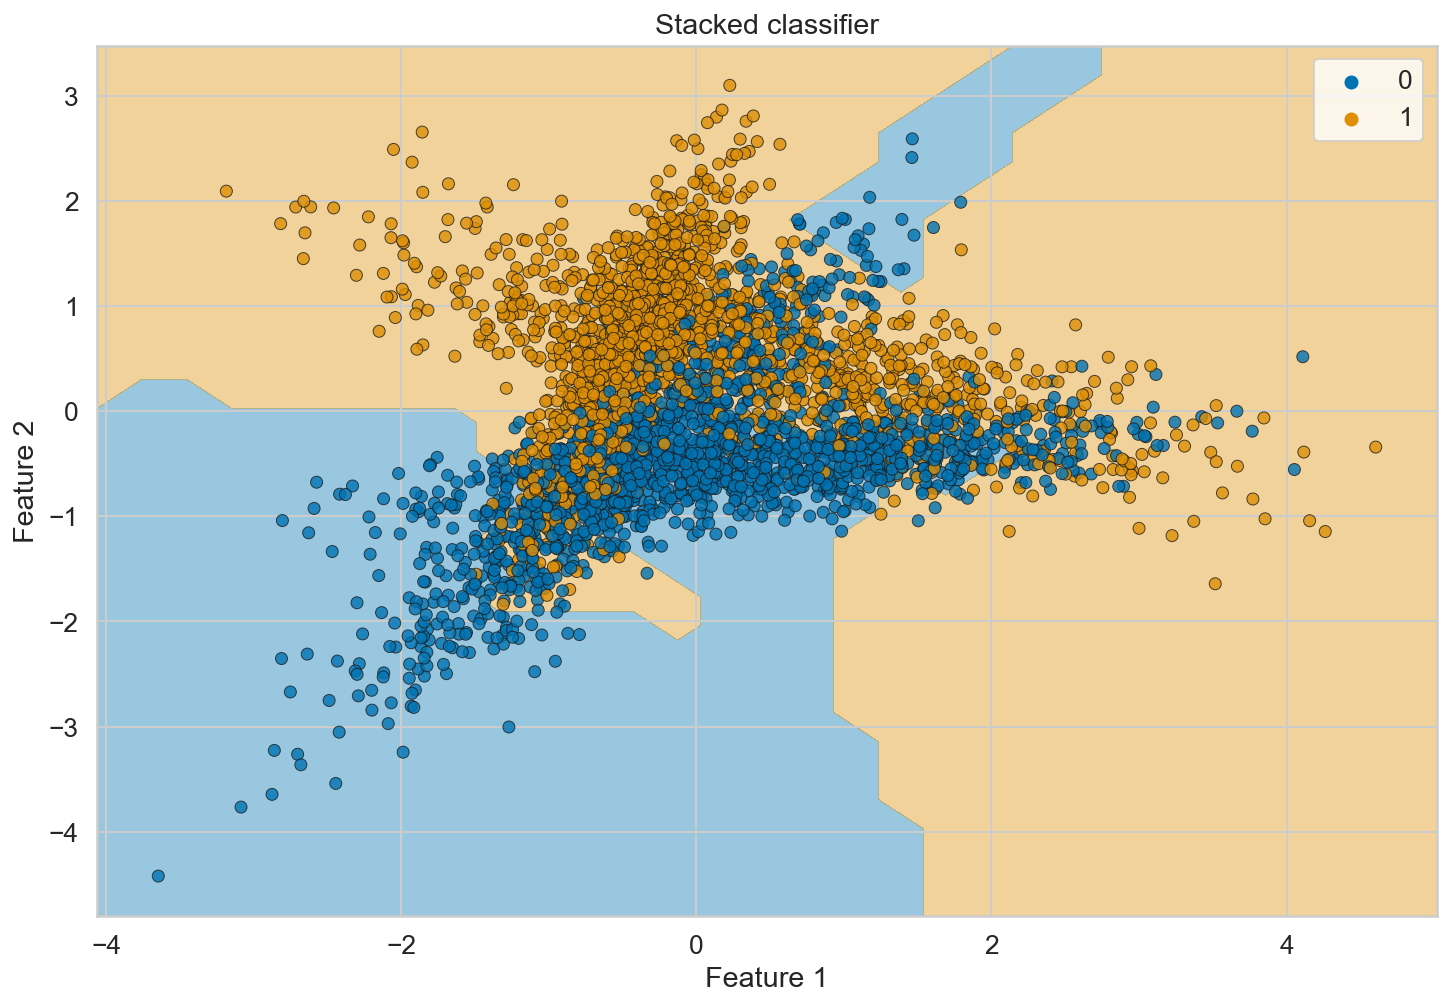

In [41]:
# Plot model
plot_decision_regions(X_train.values, y_train.values, stacked)
plt.title('Stacked classifier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

# Recap

![](images/ensemble-all-the-things.jpg)

In this lesson we covered the different techniques available to ensemble models in sklearn. 

Things to note:
- Max Voting returns the most common class out of the classifiers (similar to how KNN works)
- Average Voting returns the most likely class given all of the probabilities (similar to how Naive Bayes works)
- Weighted Voting returns the most likely class given the weighted sum of probabilities
- Finding the optimal weights to Weighted Voting can be difficult to achieve
- Stacked Classifiers use the outputs of the models as features into the meta-classifier

## Pros/Cons of Ensemble Methods

**Pros:**
- Reduces variance
- (generally) better model performance

**Cons:**
- Loss of model interpretability
- Possibility of high bias if data is not modeled properly
- Computationally expensive

# Resources
- http://people.csail.mit.edu/rivest/pubs/APR07.pdf
- http://www.mit.edu/~9.520/spring06/Classes/class10.pdf
